<a href="https://colab.research.google.com/github/stellagerantoni/MLChallenge/blob/main/traffic_lights._part_1ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, balanced_accuracy_score, log_loss

In [ ]:
!unzip "/content/drive/MyDrive/GTSRB-Training_fixed" -d "/content/"

In [4]:
import random as python_random
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)

RANDOM_STATE = 39

In [5]:
#import zipfile
#import csv

train_images = []
train_labels = []
validation_images = []
validation_labels = []
test_images = []
test_labels = []
annotations=[]

In [6]:
# Importing the training data, its labels and the x,y values to cut the images and keep only the object we want the model to detect

root_folder = '/content/GTSRB/Training/'
dir_list_classes = sorted(os.listdir(root_folder))
for path in dir_list_classes[0:43]:
  dir_list_images = sorted(os.listdir(os.path.join(root_folder,path)))
  annotation = pd.read_csv(os.path.join(root_folder,path,dir_list_images[-1]),delimiter = ';')
  img_nb = 0
  for file in dir_list_images[:150]:
    img_path = os.path.join(root_folder,path)
    img = cv2.imread(os.path.join(img_path, file))

    x1 = annotation.loc[img_nb,'Roi.X1']
    y1 = annotation.loc[img_nb,'Roi.Y1']
    x2 = annotation.loc[img_nb,'Roi.X2']
    y2 = annotation.loc[img_nb,'Roi.Y2']

    cropped_img = img[y1:y2, x1:x2]

    resized_img = cv2.resize(cropped_img, (100, 100))
    train_images.append(resized_img)

    class_id = annotation.loc[img_nb,'ClassId']
    train_labels.append(class_id)
    img_nb +=1

In [7]:
# Importing the testing data, its labels and the x,y values to cut the images and keep only the object we want the model to detect

root_folder_test = '/content/drive/MyDrive/Classroom/Final_Test/Images'
root_folder_test_dir = sorted(os.listdir(root_folder_test))
annotation_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GT-final_test.csv',delimiter = ';')
img_idx = 0
for path in root_folder_test_dir[0:12629]:
    img_path = os.path.join(root_folder_test,path)
    img = cv2.imread(img_path)

    x1 = annotation_test.loc[img_idx,'Roi.X1']
    y1 = annotation_test.loc[img_idx,'Roi.Y1']
    x2 = annotation_test.loc[img_idx,'Roi.X2']
    y2 = annotation_test.loc[img_idx,'Roi.Y2']

    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, (100, 100))

    class_id_test = annotation_test.loc[img_idx,'ClassId']
    test_labels.append(class_id_test)

    test_images.append(resized_img)
    img_idx +=1

In [8]:
#shuffling the training data (testing data is already in no purticular order), and spliting the training data so that 20% becomes validation data.

from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state=RANDOM_STATE)

from sklearn.model_selection import train_test_split
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [9]:
#converting everything to a numpy array and normalizing the images so that all the values of the pixels are from 0 to 1.

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

train_images = train_images/255.0
test_images = test_images/255.0
validation_images = validation_images/255.0

In [10]:
#transforming the labels so that they are in a one hot encoding form for the model.
from keras.utils import to_categorical

train_labels_categorical = to_categorical(train_labels, num_classes = 43)
validation_labels_categorical = to_categorical(validation_labels, num_classes = 43)
test_labels_categorical = to_categorical(test_labels, num_classes = 43)

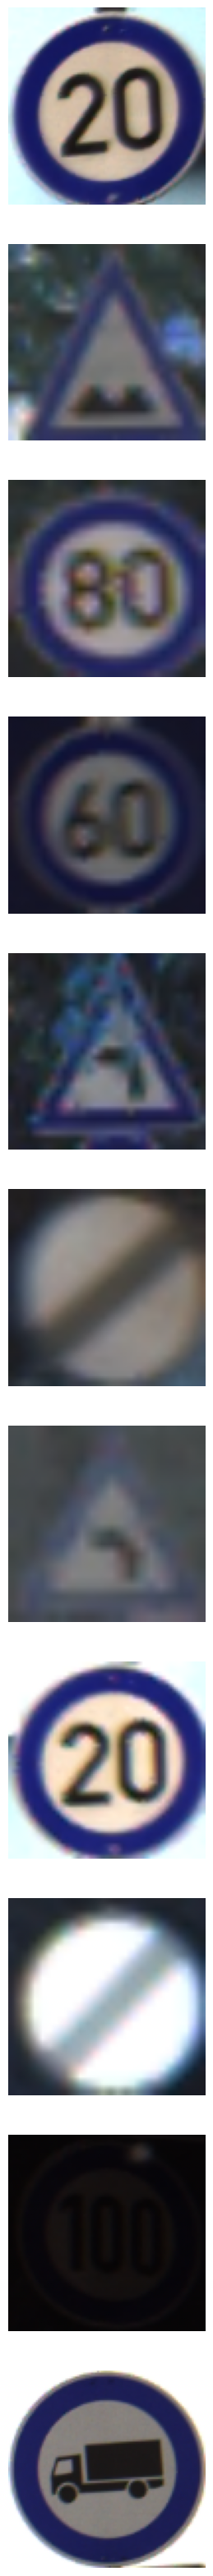

In [43]:
#just vitualising some photos to make shure that we cut the outline correctly
plt.figure(figsize=(60, 160))
count = 1
for j in range(train_images.shape[0]):
  if j %500 == 0:
    for i, image in enumerate(train_images[j:j+1]):
        plt.subplot(43, 1, count)
        plt.imshow(train_images[j])
        plt.axis('off')
        count += 1

plt.show()

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras

In [13]:
model_1 = tf.keras.Sequential([
    (Conv2D(32,kernel_size=(3,3), activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(64,kernel_size=(3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(64, activation= 'relu')),
    (Dense(43, activation = 'softmax'))
])

Epoch 1/150
162/162 [==============================] - 13s 17ms/step - loss: 3.0586 - accuracy: 0.2256 - val_loss: 2.2592 - val_accuracy: 0.4636
Epoch 2/150
162/162 [==============================] - 2s 11ms/step - loss: 1.5630 - accuracy: 0.6277 - val_loss: 1.1963 - val_accuracy: 0.6783
Epoch 3/150
162/162 [==============================] - 2s 11ms/step - loss: 0.9061 - accuracy: 0.7814 - val_loss: 0.7315 - val_accuracy: 0.8349
Epoch 4/150
162/162 [==============================] - 2s 11ms/step - loss: 0.5771 - accuracy: 0.8645 - val_loss: 0.5386 - val_accuracy: 0.8783
Epoch 5/150
162/162 [==============================] - 2s 11ms/step - loss: 0.4165 - accuracy: 0.9058 - val_loss: 0.4331 - val_accuracy: 0.9047
Epoch 6/150
162/162 [==============================] - 2s 11ms/step - loss: 0.3124 - accuracy: 0.9271 - val_loss: 0.4105 - val_accuracy: 0.9031
Epoch 7/150
162/162 [==============================] - 2s 11ms/step - loss: 0.2717 - accuracy: 0.9384 - val_loss: 0.5739 - val_accuracy

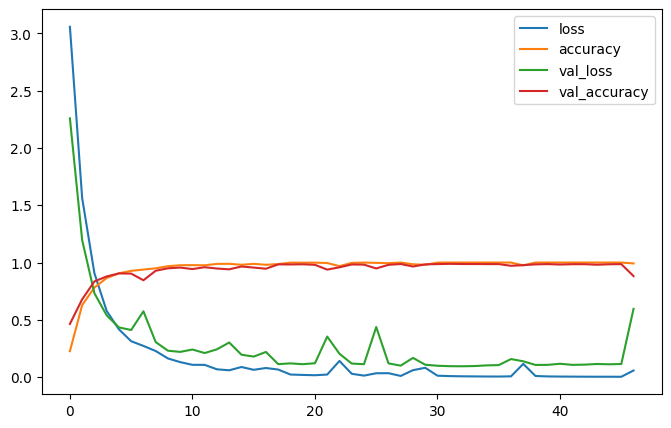

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
reset_seeds()
classifier_history_1 = model_1.fit(
    train_images,
    train_labels_categorical,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)
y_pred = model_1.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
test_loss = log_loss(test_labels,y_pred)
print(f"Classifier trained, with validation accuracy {acc}.")
pd.DataFrame(classifier_history_1.history).plot(figsize=(8,5))
plt.show()

In [15]:
model_2 = tf.keras.Sequential([
    (Conv2D(32,kernel_size=(3,3), activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(64,kernel_size=(3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(128, activation= 'relu')),
    (Dropout(0.5)),
    (Dense(43, activation = 'softmax'))
])

Epoch 1/150
162/162 [==============================] - 4s 15ms/step - loss: 3.5130 - accuracy: 0.0812 - val_loss: 3.0918 - val_accuracy: 0.2062
Epoch 2/150
162/162 [==============================] - 2s 11ms/step - loss: 2.9304 - accuracy: 0.2124 - val_loss: 2.3334 - val_accuracy: 0.5085
Epoch 3/150
162/162 [==============================] - 2s 11ms/step - loss: 2.3369 - accuracy: 0.3647 - val_loss: 1.7115 - val_accuracy: 0.6605
Epoch 4/150
162/162 [==============================] - 2s 11ms/step - loss: 1.9220 - accuracy: 0.4680 - val_loss: 1.3808 - val_accuracy: 0.7465
Epoch 5/150
162/162 [==============================] - 2s 11ms/step - loss: 1.6715 - accuracy: 0.5316 - val_loss: 1.0831 - val_accuracy: 0.8264
Epoch 6/150
162/162 [==============================] - 2s 11ms/step - loss: 1.4357 - accuracy: 0.6004 - val_loss: 0.8141 - val_accuracy: 0.8674
Epoch 7/150
162/162 [==============================] - 2s 11ms/step - loss: 1.2434 - accuracy: 0.6506 - val_loss: 0.6941 - val_accuracy:

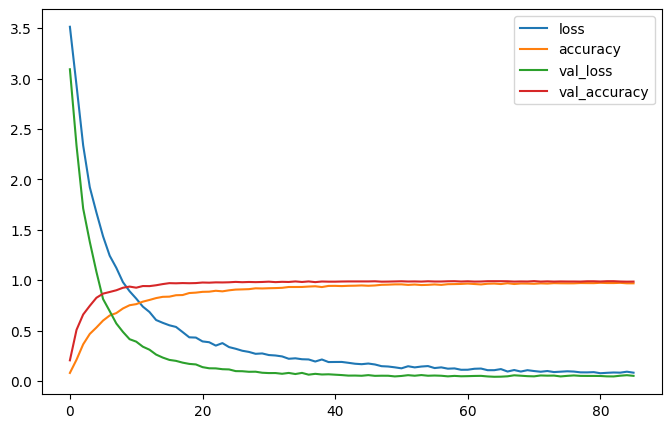

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
reset_seeds()
classifier_history_2 = model_2.fit(
    train_images,
    train_labels_categorical,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)
y_pred = model_2.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
test_loss = log_loss(test_labels,y_pred)
print(f"Classifier trained, with validation accuracy {acc}.")
pd.DataFrame(classifier_history_2.history).plot(figsize=(8,5))
plt.show()

In [17]:
model_3 = tf.keras.Sequential([
    (Conv2D(16,kernel_size=(3,3), activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(32,kernel_size=(3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(64, kernel_size = (3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(64, activation= 'relu')),
    (Dropout(0.5)),
    (Dense(43, activation = 'softmax'))
])

Epoch 1/150
162/162 [==============================] - 4s 13ms/step - loss: 3.6716 - accuracy: 0.0537 - val_loss: 3.4388 - val_accuracy: 0.1070
Epoch 2/150
162/162 [==============================] - 1s 8ms/step - loss: 3.2639 - accuracy: 0.1359 - val_loss: 2.8274 - val_accuracy: 0.3016
Epoch 3/150
162/162 [==============================] - 1s 8ms/step - loss: 2.7602 - accuracy: 0.2620 - val_loss: 2.1546 - val_accuracy: 0.5202
Epoch 4/150
162/162 [==============================] - 1s 8ms/step - loss: 2.2241 - accuracy: 0.3988 - val_loss: 1.5679 - val_accuracy: 0.6961
Epoch 5/150
162/162 [==============================] - 1s 8ms/step - loss: 1.8012 - accuracy: 0.5099 - val_loss: 1.1830 - val_accuracy: 0.7930
Epoch 6/150
162/162 [==============================] - 1s 8ms/step - loss: 1.5102 - accuracy: 0.5882 - val_loss: 0.9014 - val_accuracy: 0.8473
Epoch 7/150
162/162 [==============================] - 1s 8ms/step - loss: 1.2817 - accuracy: 0.6446 - val_loss: 0.7077 - val_accuracy: 0.887

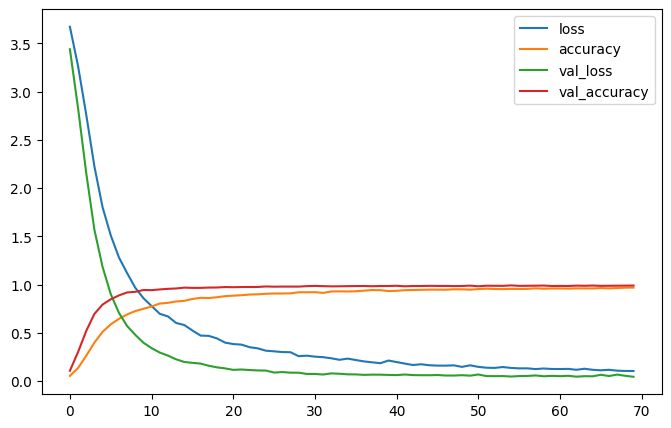

In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_3.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
reset_seeds()
classifier_history_3 = model_3.fit(
    train_images,
    train_labels_categorical,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)
y_pred = model_3.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
test_loss = log_loss(test_labels,y_pred)
print(f"Classifier trained, with validation accuracy {acc}.")
pd.DataFrame(classifier_history_3.history).plot(figsize=(8,5))
plt.show()

In [19]:
model_4 = tf.keras.Sequential([
    (Conv2D(32,kernel_size=(3,3), activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(64,kernel_size=(3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(128, kernel_size = (3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(128, activation= 'relu')),
    (Dropout(0.5))
    (Dense(43, activation = 'softmax'))
])

Epoch 1/150
162/162 [==============================] - 5s 17ms/step - loss: 3.3836 - accuracy: 0.1378 - val_loss: 2.6962 - val_accuracy: 0.3031
Epoch 2/150
162/162 [==============================] - 2s 12ms/step - loss: 1.7499 - accuracy: 0.5785 - val_loss: 1.2071 - val_accuracy: 0.7140
Epoch 3/150
162/162 [==============================] - 2s 12ms/step - loss: 0.7652 - accuracy: 0.8256 - val_loss: 0.5243 - val_accuracy: 0.8829
Epoch 4/150
162/162 [==============================] - 2s 12ms/step - loss: 0.3464 - accuracy: 0.9275 - val_loss: 0.2950 - val_accuracy: 0.9426
Epoch 5/150
162/162 [==============================] - 2s 12ms/step - loss: 0.2221 - accuracy: 0.9514 - val_loss: 0.2325 - val_accuracy: 0.9481
Epoch 6/150
162/162 [==============================] - 2s 12ms/step - loss: 0.1262 - accuracy: 0.9738 - val_loss: 0.1996 - val_accuracy: 0.9558
Epoch 7/150
162/162 [==============================] - 2s 12ms/step - loss: 0.0768 - accuracy: 0.9870 - val_loss: 0.1509 - val_accuracy:

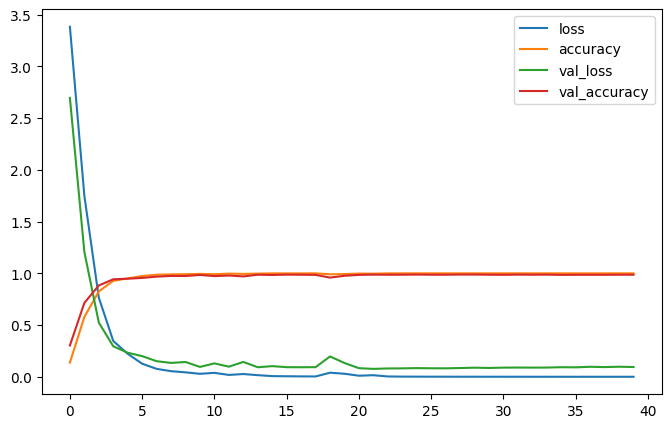

In [20]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_4.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
reset_seeds()
classifier_history_4 = model_4.fit(
    train_images,
    train_labels_categorical,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)
y_pred = model_4.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
test_loss = log_loss(test_labels,y_pred)
print(f"Classifier trained, with validation accuracy {acc}.")
pd.DataFrame(classifier_history_4.history).plot(figsize=(8,5))
plt.show()

In [29]:
model_5 = tf.keras.Sequential([
    (Conv2D(32,kernel_size=(3,3), activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(64,kernel_size=(3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(128, kernel_size = (3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(256, kernel_size = (3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(256, activation= 'relu')),
    (Dropout(0.5)),
    (Dense(43, activation = 'softmax'))
])

Epoch 1/150
162/162 [==============================] - 5s 18ms/step - loss: 0.2935 - accuracy: 0.9267 - val_loss: 0.1123 - val_accuracy: 0.9791
Epoch 2/150
162/162 [==============================] - 2s 14ms/step - loss: 0.1762 - accuracy: 0.9523 - val_loss: 0.0968 - val_accuracy: 0.9837
Epoch 3/150
162/162 [==============================] - 2s 14ms/step - loss: 0.1408 - accuracy: 0.9649 - val_loss: 0.0752 - val_accuracy: 0.9783
Epoch 4/150
162/162 [==============================] - 2s 14ms/step - loss: 0.0998 - accuracy: 0.9762 - val_loss: 0.0394 - val_accuracy: 0.9930
Epoch 5/150
162/162 [==============================] - 2s 14ms/step - loss: 0.0814 - accuracy: 0.9787 - val_loss: 0.0370 - val_accuracy: 0.9938
Epoch 6/150
162/162 [==============================] - 2s 14ms/step - loss: 0.0489 - accuracy: 0.9880 - val_loss: 0.0546 - val_accuracy: 0.9899
Epoch 7/150
162/162 [==============================] - 2s 14ms/step - loss: 0.0958 - accuracy: 0.9725 - val_loss: 0.0331 - val_accuracy:

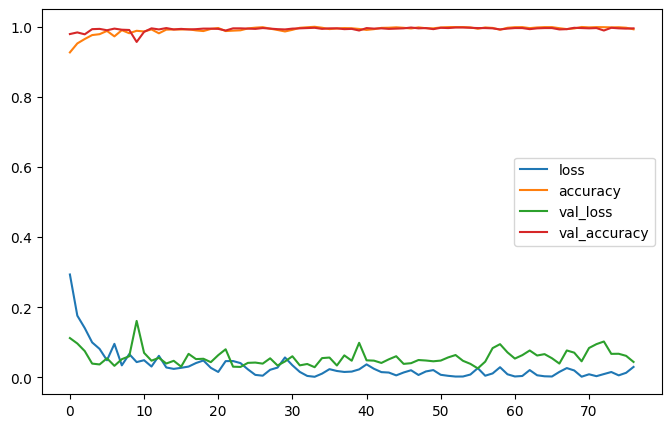

In [33]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_5.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
reset_seeds()
classifier_history_5= model_5.fit(
    train_images,
    train_labels_categorical,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)
y_pred = model_5.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
test_loss = log_loss(test_labels,y_pred)
print(f"Classifier trained, with validation accuracy {acc}.")
pd.DataFrame(classifier_history_5.history).plot(figsize=(8,5))
plt.show()

In [36]:
model_6 = tf.keras.Sequential([
    (Conv2D(32,kernel_size=(3,3), activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(64,kernel_size=(3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(128, kernel_size = (3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(256, kernel_size = (3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(256, activation= 'relu')),
    (Dropout(0.5)),
    (Dense(43, activation = 'softmax'))
])

Epoch 1/64
41/41 [==============================] - 4s 47ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0277 - val_accuracy: 0.9953
Epoch 2/64
41/41 [==============================] - 2s 42ms/step - loss: 0.0109 - accuracy: 0.9983 - val_loss: 0.0402 - val_accuracy: 0.9922
Epoch 3/64
41/41 [==============================] - 2s 43ms/step - loss: 5.6831e-04 - accuracy: 0.9998 - val_loss: 0.0359 - val_accuracy: 0.9961
Epoch 4/64
41/41 [==============================] - 2s 43ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0093 - val_accuracy: 0.9969
Epoch 5/64
41/41 [==============================] - 2s 43ms/step - loss: 0.0165 - accuracy: 0.9965 - val_loss: 0.0184 - val_accuracy: 0.9961
Epoch 6/64
41/41 [==============================] - 2s 42ms/step - loss: 0.0147 - accuracy: 0.9961 - val_loss: 0.0465 - val_accuracy: 0.9961
Epoch 7/64
41/41 [==============================] - 2s 42ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0519 - val_accuracy: 0.9953
Epoch 8/6

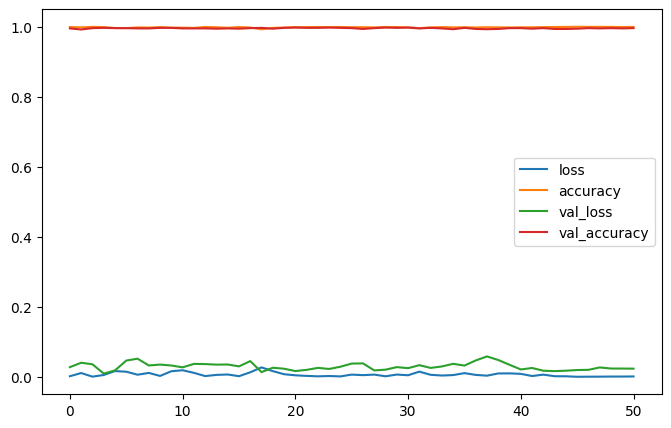

In [41]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_6.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
reset_seeds()
classifier_history_6= model_6.fit(
    train_images,
    train_labels_categorical,
    epochs=64,
    batch_size=128,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)
y_pred = model_6.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
test_loss = log_loss(test_labels,y_pred)
print(f"Classifier trained, with testing accuracy {acc}.")
pd.DataFrame(classifier_history_6.history).plot(figsize=(8,5))
plt.show()